In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import iminuit
import scipy.optimize as optimize

#sns.set_theme()

# **JFET with explicit temperature dependance**
*Electronic devices exhibit very different behavior when they operate at different temperatures. To produce robust simulations, a model that includes explicit temperature dependence is necessary. The goal of this notebook is to implement a class describing the behavior of a JFET with explicit temperature dependence.*

## Mobility: phonon scattering
The first step of our implementation is to explore how the mobility of both electrons and holes varies as a function of temperature. We consider the basic phonon scattering model proposed by Sah et al [1] and presented in [2] (p. 29):

$$
\mu_{ps}(T) = \left[\frac{1}{\frac{1}{\mu_{0a}(\frac{T}{T_0})^{-\alpha}}}+\frac{1}{\frac{1}{\mu_{0b}(\frac{T}{T_0})^{-\beta}}}\right]
$$

with: $\mu_{0a,e} = 4195~\text{cm}^2/\text{V s}$, $\mu_{0b,e} = 2153~\text{cm}^2/\text{V s}$, $\alpha_{e}=1.5$, $\beta_{e}=3.13$ for electrons; $\mu_{0a,h} = 2502~\text{cm}^2/\text{V s}$, $\mu_{0b,h} = 591~\text{cm}^2/\text{V s}$, $\alpha_{h}=1.5$, $\beta_{h}=3.25$ for holes. $T_0$ is setted at 300 K.

In this model, optical phonons are combined with acoustic phonons using Mathiessen's rule. A more sophisticated expression for mobility could be derived by accounting for additional scattering mechanisms, such as ionized-impurity scattering or carrier-carrier scattering. However, for our purposes, we limit our analysis to this simplified model.

----------
[1] C. T. Sah, P. C. H. Chan, C. K. Wang, R. L. Sah, K. A. Yamakawa, and R. Lutwack, "Effect of zinc impurity in silicon solar-cell efficiency," IEEE Trans. Electron Devices ED-28(3), 304-313 (1981).

[2] Gutierrez-D, Edmundo A., M. Jamal Deen, and Cor L. Claeys. Low temperature electronics: physics, devices, circuits, and applications. Academic Press, 2001.

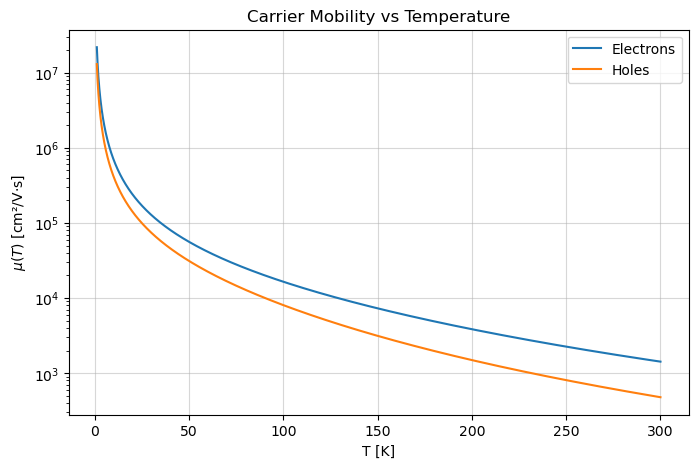

In [3]:
def mobility(T, alpha, beta, mu_0a, mu_0b, T_0=300):
    rateo = T / T_0
    A = 1/(mu_0a * rateo**(-alpha))
    B = 1/(mu_0b * rateo**(-beta))

    return 1/(A + B)

Ts = np.arange(1, 300, 0.01)  

# Electrons
alpha_e = 1.5
beta_e = 3.13
mu_0ea = 4195  # cm^2/V s
mu_0eb = 2153  # cm^2/V s

# Holes
alpha_h = 1.5
beta_h = 3.25
mu_0ha = 2502   # cm^2/V s
mu_0hb = 591    # cm^2/V s

mu_values_e = [mobility(t, alpha_e, beta_e, mu_0ea, mu_0eb) for t in Ts]
mu_values_h = [mobility(t, alpha_h, beta_h, mu_0ha, mu_0hb) for t in Ts]

plt.figure(figsize=(8, 5))
plt.plot(Ts, mu_values_e, label="Electrons")
plt.plot(Ts, mu_values_h, label="Holes")
plt.yscale("log")
plt.xlabel("T [K]")
plt.ylabel("$\mu(T)$ [cm²/V·s]")
plt.title("Carrier Mobility vs Temperature")
plt.legend()
plt.grid(alpha=0.5)
plt.show()

## Density of states in the conduction band wrt temperature

The second crucial aspect is understanding how the density of states in the conduction band of the JFET varies as a function of temperature. The density of states in the conduction band ([3], p. 18) can be expressed as:
$$
N_C(T) = 2 \left( \frac{2 \pi m_{de} k_b T}{h^2}\right)^{\frac{3}{2}} M_C
$$

where $m_{de} = (m^*_l (m^*_t)^2)^{1/3} \approx 0.328$ is the density-of-state effective mass for electrons and $M_C$ is the number of equivalent minima in the conduction band. The value of $M_C \approx 8.052 \cdot 10^{-23}$ is infered knowing that $N_C(T=300)=2.8 \cdot 10^{19}$ for electrons in Si. 

-----
[3] Sze, Simon M., Yiming Li, and Kwok K. Ng. Physics of semiconductor devices. John wiley & sons, 2021.

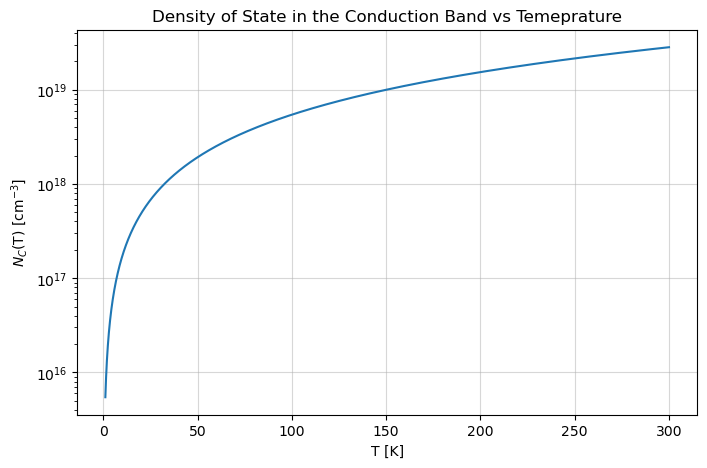

2.832032385900525e+19


In [4]:
def density_of_state_cond_band(T):
    M_c = 6
    h = 6.62607015e-34 #mˆ2 kg/s
    k_b = 1.380649e-23 #mˆ2 kg sˆ-2 Kˆ-1
    m_0 = 9.1095e-31 #kg
    m_l = 0.98*m_0
    m_t = 0.19*m_0
    m_de = (m_l * m_t**2)**(1/3)

    num = 2*np.pi * m_de * k_b * T
    den = h**2

    return (2* M_c*(num/den)**1.5)*1e-6


Ts = np.arange(1, 300, 0.01) 

plt.figure(figsize=(8, 5))
plt.plot(Ts, density_of_state_cond_band(Ts))
plt.title("Density of State in the Conduction Band vs Temeprature")
plt.xlabel("T [K]")
plt.ylabel("$N_C$(T) [cm$^{-3}$]")
plt.yscale("log")
plt.grid(alpha=0.5)
plt.show()


print(density_of_state_cond_band(300))

## The JFET class

At this point, we are ready to implement a Python class to simulate the JFET with explicit temperature dependence. The model is based on the framework presented in [3] (p. 379).

The density of states in the conduction band is given by:

$$
N_C(T) = 2 \left( \frac{2 \pi m_{de} k_b T}{h^2}\right)^{\frac{3}{2}} M_C
$$


Using this, we compute the energy gap at the operating temperature $T$ starting from the energy gap $E_g(T_0)$ at T=300 K:
$$
E_g(T) \approx E_g(0)-\frac{\alpha T^2}{T+\beta}= \left( E_g(T_0) + \frac{\alpha T^2_0}{T_0 + \beta}\right)- \frac{\alpha T^2}{T+\beta}
$$
with $\alpha$ and $\beta$ are empirical constants for Si ([3] pp. 15-16).

This energy gap is then used to evaluate the built-in potentia $\Psi_{bi}$ combined with $N_C(T)$:
$$
\Psi_{bi}(T)\approx \frac{1}{q}\left[E_g(T) - k_b T \log\left( \frac{N_C(T)}{N_D}\right) \right]
$$
where $k_b$ is the Boltzman constant.

Given the donor concentration $N_D$, the channel depth $a$, and the relative permittivity of Si $\epsilon_s$, the pinch-off potential is defined as:
$$
\Psi_{P}=\frac{qN_Da^2}{2\epsilon_s \epsilon_0}
$$
where $q$ is the elementary charge.


The source-drain current for the JFET is defined as:
$$
I_D = G_i(T) \left[V_D - \frac{2}{3\sqrt{\Psi_{P}}}[(\Psi_{bi}(T)+V_D-V_G)^{\frac{3}{2}}-(\Psi_{bi}(T)-V_G)^{\frac{3}{2}}] \right]
$$

where:
$$
G_i(T) = \frac{Wq\mu(T)N_Da}{L}
$$
is the full-channel conductance, and 
$$
\mu(T) = \left[\frac{1}{\frac{1}{\mu_{0a}(\frac{T}{T_0})^{-\alpha}}}+\frac{1}{\frac{1}{\mu_{0b}(\frac{T}{T_0})^{-\beta}}}\right]
$$
represents the temperature-dependent electron mobility.

The activation theshold voltage of the JFET is 
$$
V_{TO}=\Psi_{bi}-\Psi_P
$$
while the saturation voltage is defined as:
$$
V_{SAT} = \Psi_P -\Psi_{bi}+V_G
$$



### Class Inputs
The class takes the following free input parameters:
* $\frac{W}{L}$: ratio betweem channel width and channel length
* $a$: channel depth
* $N_D$: donor doping concentration

Other tunable parameters for specific JFETs (with default values corresponding to Si):
* $E_g$: Energy gap at $T_0$
* $\alpha$: parameter to adjust $E_g$ with temperature
* $\beta$: parameter to adjust $E_g$ with temperature
* $\epsilon_s$: relative permettivity of the semiconductor
* $T_0$: reference temperature

The main method of the class is $\texttt{Id()}$ which computes the drain-source current as function of the drain-source voltage $V_{DS}$, the gate-source voltage $V_{GS}$ and temperature $T$. Additionally, the method accepts the paramete $\texttt{lambda mod}$, which represents the channel-length modulation factor in the saturation region.




-------
[3] Sze, Simon M., Yiming Li, and Kwok K. Ng. Physics of semiconductor devices. John wiley & sons, 2021.

In [5]:
class JFET:
    def __init__(self, W_L_ratio, a, N_d, E_g=1.12, alpha=5.4e-4, beta=655, eps_s=11.9, T_0=300):
        """
        Class that simulate JFETs with explicit temperature dependance

        Parameters:
        -----------
        mu_0 : float
            Mobility at reference temperature T_0 [cm^2/(V*s)]
        W_L_ratio : float
            Ratio betweem channel width and channel lenght
        a : float
            Channel depth [m]
        N_d : float
            Donor doping concentration [cm^-3]
        E_g : float
            Bandgap energy [eV]
        alpha : float 
            Parameter to adjust E_g with temperature [eV/K]
        beta : float
            Parameter to adjust E_g with temperature [K]
        eps_s : float
            Relative permittivity of the semiconductor
        T_0 : float
            Reference temperature [K]
        """

        self.W_L_ratio = W_L_ratio
        self.a = a
        self.N_d = N_d
        self.E_g = E_g
        self.alpha = alpha
        self.beta = beta
        self.eps_s = eps_s
        self.T_0 = T_0

        self.k_b = 8.61e-5          # Boltzmann constant [eV/K]
        self.h = 4.1356e-15         # Planck constant [eV/Hz]
        self.q = 1.6e-19            # Electron charge [C]
        self.eps_0 = 8.85e-12       # Vacuum permittivity [F/m]

    def safe_power(self, x, p, tol=1e-8):
        """
        Safely compute x^p for both scalar and array inputs.
        
        - For integer exponents: Preserve sign (negative inputs allowed)
        - For fractional exponents: Clamp negative inputs to 0 to avoid NaNs
        
        Parameters:
        -----------
        x : scalar or array-like
            Input values
        p : float
            Exponent
        tol : float, optional
            Tolerance for checking if exponent is an integer
        
        Returns:
        --------
        scalar or ndarray
            Result of x^p with safety checks
        """
        x = np.asarray(x)
        p_rounded = np.round(p)
        is_integer = np.isclose(p, p_rounded, atol=tol)
        
        if is_integer:
            # Integer exponent: preserve sign for odd exponents
            p_int = int(p_rounded)
            abs_result = np.abs(x) ** p_int
            if p_int % 2 == 1:  # Odd exponent
                return np.sign(x) * abs_result
            else:  # Even exponent
                return abs_result
        else:
            # Fractional exponent: clamp negative values to 0
            x_clamped = np.maximum(x, 0)
            return x_clamped ** p
    
    def density_of_state_cond_band(self, T):
        """
        Calculate the number of states in the conduction band as function of temperature
        """
        m_de = (0.98 * 0.19**2)**(1/3)      
        M_c = 8.052e-23                     
        num = 2*np.pi * m_de * self.k_b * T

        return 2 * M_c *(num/(self.h**2))**1.5
    
    def energy_gap(self, T):
        """
        Calculate the energy gap as a function of temperature
        """
        E_g_0 = self.E_g + (self.alpha * self.T_0**2) / (self.T_0 + self.beta)      # Infer E_g @ 0 K form E_g @ T_0

        return E_g_0 - (self.alpha * T**2) / (T + self.beta)

    def built_in_potential(self, T):
        """
        Calculate the built-in potential as a function of temperature
        """
        N_c = self.density_of_state_cond_band(T)
        E_g_T = self.energy_gap(T)
        ln_term = np.log(N_c / self.N_d)

        return E_g_T - self.k_b * T * ln_term

    def pinch_off_voltage(self):
        """
        Calculate the pinch-off voltage for the JFET
        """
        N_d_m3 = self.N_d * 1e6  # Convert from cm^-3 to m^-3

        return (self.q * N_d_m3 * self.a**2) / (2 * self.eps_s * self.eps_0)

    
    def mobility(self, T):
        """
        Calculate electrons mobility as a function of temperature
        """       
        m_alpha = 1.5
        m_beta = 3.13
        mu_0ea = 4195  # cm^2/V s
        mu_0eb = 2153  # cm^2/V s

        rateo = T / self.T_0
        A = 1 / (mu_0ea * rateo**(-m_alpha))
        B = 1 / (mu_0eb * rateo**(-m_beta))

        return 1/(A+B)
    
    def full_channel_conductance(self, mu):
        """
        Calculate the full-channel conductance
        """
        N_d_m3 = self.N_d * 1e6  # Convert from cm^-3 to m^-3

        return self.W_L_ratio * self.q * N_d_m3 * self.a * mu

    def I_d(self, V_ds, V_gs, T, lambda_mod=0):
        """
        Calculate the drain-source current for given conditions

        Parameters:
        -----------
        V_ds : scalar or array
            Drain-source voltage [V]
        V_gs : scalar or array
            Gate-source voltage [V]
        T : float
            Temperature [K]
        lambda_mod : float, optional
            Channel-length modulation factor

        Returns:
        --------
        array
            Drain-Source current [A]
        """

        V_bi = self.built_in_potential(T)
        V_p = self.pinch_off_voltage()
        mu = self.mobility(T)
        G = self.full_channel_conductance(mu)

        V_T = V_bi - V_p            # Threshold voltage
        V_sat = V_p - V_bi + V_gs   # Saturation voltage

        V_ds = np.asarray(V_ds)
        V_gs = np.asarray(V_gs)

        I_d = np.zeros_like(V_ds)

        # Regions definition
        linear_region = V_gs >= V_T
        saturation_region = (V_ds >= V_sat) & linear_region

        # Linear region
        I_d[linear_region] = (
            G * (
                V_ds[linear_region]
                - (2 / (3 * np.sqrt(V_p))) * self.safe_power(V_bi + V_ds[linear_region] - V_gs[linear_region], 1.5)
                + (2 / (3 * np.sqrt(V_p))) * self.safe_power(V_bi - V_gs[linear_region], 1.5)
                )
            )
        # Saturation region
        I_d[saturation_region] = (
            G * (
                V_sat[saturation_region]
                - (2 / (3 * np.sqrt(V_p))) * self.safe_power(V_bi + V_sat[saturation_region] - V_gs[saturation_region], 1.5)
                + (2 / (3 * np.sqrt(V_p))) * self.safe_power(V_bi - V_gs[saturation_region], 1.5)
                )
            ) * (1 + lambda_mod * (V_ds[saturation_region] - V_sat[saturation_region]))

        return I_d

## Test the JFET class

Firsly, let's test the class with some toy parameters:

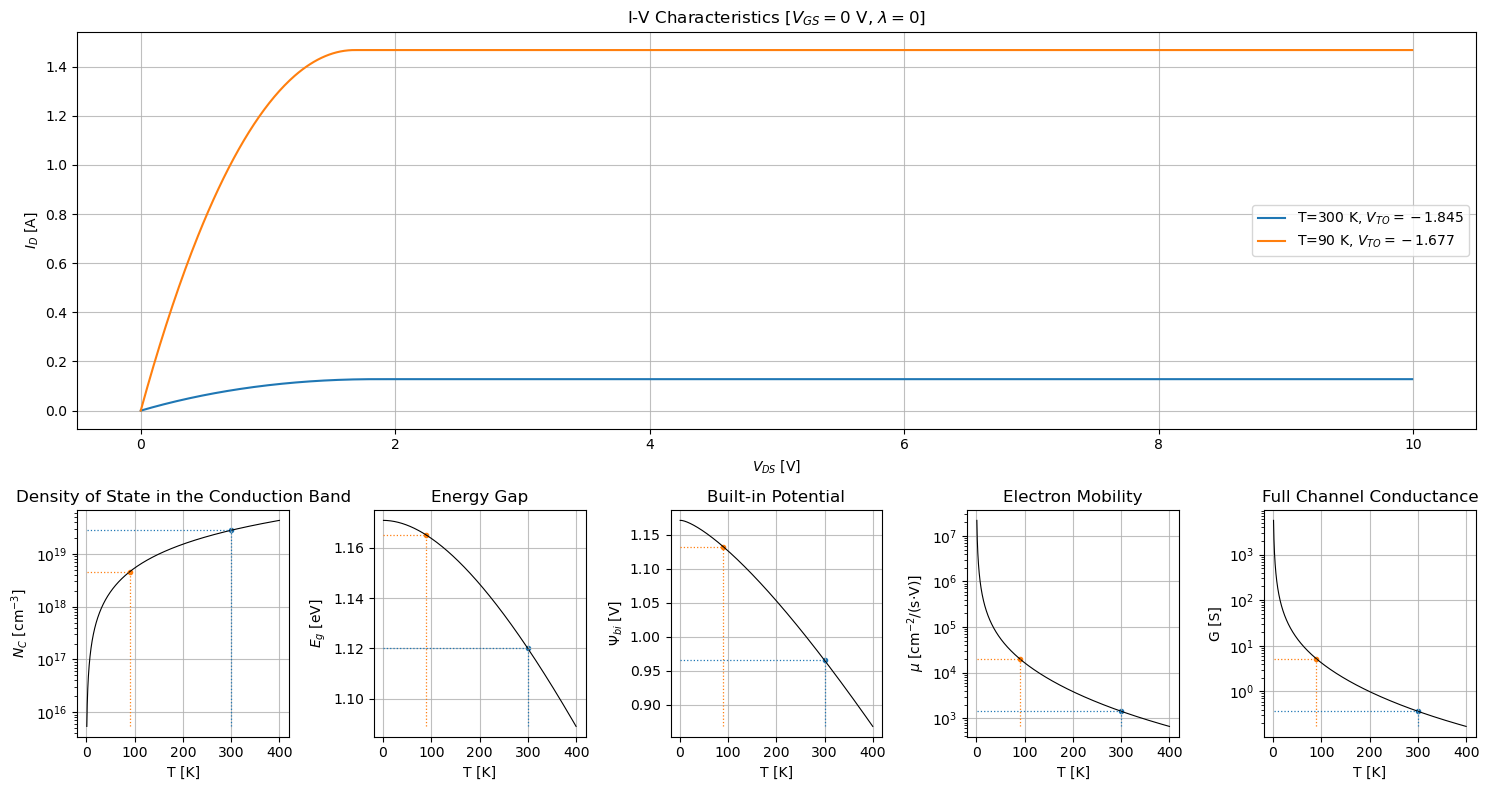

In [6]:
# Params
W = 1e-6
L = 10e-6
W_L_ratio = W/L

T_0 = 300
T = 90
lambda_mod = 0
V_gs = 0
T_values = [T_0,T]

# Initialize class
jfet=JFET(  
    W_L_ratio = W_L_ratio,
    a = 230e-9,                               
    N_d = 7e16,        
    )

# Define ranges for plots
Ts = np.arange(1, 400, 0.1)
V_ds = np.arange(0,10,0.01)

# Compute quantities
id_values = [[jfet.I_d(V_ds=i, V_gs=V_gs, T=t, lambda_mod=lambda_mod) for i in V_ds] for t in T_values]
N_c = jfet.density_of_state_cond_band(Ts)
V_p = round(jfet.pinch_off_voltage(),2)
E_g = jfet.energy_gap(Ts)
V_bi = jfet.built_in_potential(Ts)
mu = [jfet.mobility(t) for t in Ts]
G = [jfet.full_channel_conductance(m) for m in mu]

# Plots
fig = plt.figure(figsize=(15, 8))
gs = fig.add_gridspec(2, 5, height_ratios=[1.75, 1])  

ax0 = fig.add_subplot(gs[0, :])  
for i, t in enumerate(T_values):
    ax0.plot(V_ds, id_values[i], label=f"T={t} K, $V_{{TO}}={np.round(jfet.built_in_potential(t)-V_p,3)}$")
ax0.legend()
ax0.set_xlabel("$V_{DS}$ [V]")
ax0.set_ylabel("$I_{D}$ [A]")
ax0.set_title(f"I-V Characteristics [$V_{{GS}} = {V_gs}$ V, $\lambda = {lambda_mod}$]")
ax0.grid(alpha=0.8)

ax1 = fig.add_subplot(gs[1, 0])
ax1.plot(Ts, N_c, label="$N_c(T)$", color="black", lw=0.8)
ax1.scatter(T, jfet.density_of_state_cond_band(T), color="tab:orange", marker=".")
ax1.vlines(T,min(N_c),jfet.density_of_state_cond_band(T), color="tab:orange", ls="dotted", lw=0.9)
ax1.hlines(jfet.density_of_state_cond_band(T), min(Ts), T, color="tab:orange", ls="dotted", lw=0.9)
ax1.scatter(T_0, jfet.density_of_state_cond_band(T_0), color="tab:blue", marker=".")
ax1.vlines(T_0,min(N_c),jfet.density_of_state_cond_band(T_0), color="tab:blue", ls="dotted", lw=0.9)
ax1.hlines(jfet.density_of_state_cond_band(T_0), min(Ts), T_0, color="tab:blue", ls="dotted", lw=0.9)
ax1.set_yscale("log")
ax1.set_xlabel("T [K]")
ax1.set_ylabel("$N_C$ [cm$^{-3}$]")
ax1.set_title("Density of State in the Conduction Band")
ax1.grid(alpha=0.8)

ax2 = fig.add_subplot(gs[1, 1])
ax2.plot(Ts, E_g, label="$\E_g(T)$", color="black", lw=0.8)
ax2.scatter(T, jfet.energy_gap(T), color="tab:orange", marker=".")
ax2.vlines(T,min(E_g),jfet.energy_gap(T), color="tab:orange", ls="dotted", lw=0.9)
ax2.hlines(jfet.energy_gap(T), min(Ts), T, color="tab:orange", ls="dotted", lw=0.9)
ax2.scatter(T_0, jfet.energy_gap(T_0), color="tab:blue", marker=".")
ax2.vlines(T_0,min(E_g),jfet.energy_gap(T_0), color="tab:blue", ls="dotted", lw=0.9)
ax2.hlines(jfet.energy_gap(T_0), min(Ts), T_0, color="tab:blue", ls="dotted", lw=0.9)
ax2.set_xlabel("T [K]")
ax2.set_ylabel("$E_g$ [eV]")
ax2.set_title("Energy Gap")
ax2.grid(alpha=0.8)

ax3 = fig.add_subplot(gs[1, 2])
ax3.plot(Ts, V_bi, label="$\Psi_{bi}(T)$", color="black", lw=0.8)
ax3.scatter(T, jfet.built_in_potential(T), color="tab:orange", marker=".")
ax3.vlines(T,min(V_bi),jfet.built_in_potential(T), color="tab:orange", ls="dotted", lw=0.9)
ax3.hlines(jfet.built_in_potential(T), min(Ts), T, color="tab:orange", ls="dotted", lw=0.9)
ax3.scatter(T_0, jfet.built_in_potential(T_0), color="tab:blue", marker=".")
ax3.vlines(T_0,min(V_bi),jfet.built_in_potential(T_0), color="tab:blue", ls="dotted", lw=0.9)
ax3.hlines(jfet.built_in_potential(T_0), min(Ts), T_0, color="tab:blue", ls="dotted", lw=0.9)
ax3.set_xlabel("T [K]")
ax3.set_ylabel("$\Psi_{bi}$ [V]")
ax3.set_title("Built-in Potential")
ax3.grid(alpha=0.8)

ax4 = fig.add_subplot(gs[1, 3])
ax4.plot(Ts, mu, label="$\mu(T)$", color="black", lw=0.8)
ax4.scatter(T, jfet.mobility(T), color="tab:orange", marker=".")
ax4.vlines(T,min(mu),jfet.mobility(T), color="tab:orange", ls="dotted", lw=0.9)
ax4.hlines(jfet.mobility(T), min(Ts), T, color="tab:orange", ls="dotted", lw=0.9)
ax4.scatter(T_0, jfet.mobility(T_0), color="tab:blue", marker=".")
ax4.vlines(T_0,min(mu),jfet.mobility(T_0), color="tab:blue", ls="dotted", lw=0.9)
ax4.hlines(jfet.mobility(T_0), min(Ts), T_0, color="tab:blue", ls="dotted", lw=0.9)
ax4.set_yscale("log")
ax4.set_xlabel("T [K]")
ax4.set_ylabel("$\mu$ [cm$^{-2}$/(s$\cdot$V)]")
ax4.set_title("Electron Mobility")
ax4.grid(alpha=0.8)

ax5 = fig.add_subplot(gs[1, 4])
ax5.plot(Ts, G, label="$G(T)$", color="black", lw=0.8)
ax5.scatter(T, jfet.full_channel_conductance(jfet.mobility(T)), color="tab:orange", marker=".")
ax5.vlines(T,min(G),jfet.full_channel_conductance(jfet.mobility(T)), color="tab:orange", ls="dotted", lw=0.9)
ax5.hlines(jfet.full_channel_conductance(jfet.mobility(T)), min(Ts), T, color="tab:orange", ls="dotted", lw=0.9)
ax5.scatter(T_0, jfet.full_channel_conductance(jfet.mobility(T_0)), color="tab:blue", marker=".")
ax5.vlines(T_0,min(G),jfet.full_channel_conductance(jfet.mobility(T_0)), color="tab:blue", ls="dotted", lw=0.9)
ax5.hlines(jfet.full_channel_conductance(jfet.mobility(T_0)), min(Ts), T_0, color="tab:blue", ls="dotted", lw=0.9)
ax5.set_yscale("log")
ax5.set_xlabel("T [K]")
ax5.set_ylabel("G [S]")
ax5.set_title("Full Channel Conductance")
ax5.grid(alpha=0.8)

plt.tight_layout()

In [7]:
# Analysis @ 300 K
mu = jfet.mobility(T=300)
G_i = jfet.full_channel_conductance(mu)
psi_bi = jfet.built_in_potential(T=300)
psi_p = jfet.pinch_off_voltage()
V_T = psi_bi - psi_p

u_s = np.sqrt((psi_bi)/psi_p)
g_m = G_i*(1-u_s) 


print("class output (T=300K):\n")
print(f" G_i: {G_i} \n psi_bi: {psi_bi} \n psi_p: {psi_p} \n V_TO: {V_T}\n\n g_m: {g_m} \n")

I_DSS_comp = max(id_values[0])                      # computed using the JFET class 
print(f" I_DSS computed: \t{I_DSS_comp}")

I_sat = G_i * (psi_p/3 - (psi_bi ) * (1-2/3*u_s))   # theoretical value 
print(f" I_DSS theoretical: \t{I_sat} \n")

class output (T=300K):

 G_i: 0.36650924637681154 
 psi_bi: 0.9652414698714751 
 psi_p: 2.8128946493851776 
 V_TO: -1.8476531795137026

 g_m: 0.15181214143666064 

 I_DSS computed: 	0.12803707509998988
 I_DSS theoretical: 	0.1280370750999899 



## Infer parameters from data sheet

Real-world datasheets typically do not provide information such as the donor concentration ($N_D$) or the geometric parameters of the JFET's channel. Instead, they commonly specify the saturation current at $V_{G}=0$ ($I_{DSS}$), the transconductance ($g_m$) and the cut-off voltage ($V_{TO}$). Using our model, these parameters can be used to infer $N_D$, $\frac{W}{L}$ and $a$ by solving the following equations:

$$
V_{TO} = \Psi_{bi} - \Psi_P =\frac{1}{q}\left[E_g(T) - k_b T \log\left( \frac{N_C(T)}{N_D}\right) \right] - \frac{qN_Da^2}{2\epsilon_s \epsilon_0}
$$

$$
g_m = G_i \left( 1 - \sqrt{\frac{\Psi_{bi}-V_{G}}{\Psi_P}}\right), \qquad G_i = \frac{W}{L}\mu(T)q N_D a
$$

$$
I_{DSS} = G_i \left[ \frac{\Psi_P}{3} - (\Psi_{bi}-V_G)\left( 1- \frac{2}{3} \sqrt{\frac{\Psi_{bi}-V_{G}}{\Psi_P}}\right)\right]
$$

with $V_G=0$. We implement a function to perform this fitting process, using either SciPy's $\texttt{differential evlolution}$ method or $\texttt{iminuit}$ as optimizer.

In [8]:
def infer_jfet_params(I_DSS, VTO, g_m, T, method='differential_evolution'):
    """
    Function that infers donor concentration and geometric channel parameters starting from JFET data sheet values
    
    Parameters:
    -----------
    I_DSS : float
        Saturation current @ V_gs = 0 [A]
    VTO : float
        Pinch off voltage [V]
    g_m : float
        Transconductance [S]
    T : float
        Nominal data sheet temperature [K]
    method : str, optional
        Optimization method to use. Options:
        - 'differential_evolution' (default): Uses SciPy's differential evolution
        - 'iminuit': Uses iMinuit for optimization (requires iminuit to be installed)
    
    Returns:
    --------
    dict
        Inferred parameters, including:
        - 'N_d': Donor concentration
        - 'W': Channel width
        - 'L': Channel length
        - 'a': Channel depth
        - 'covariance_matrix': Covariance matrix (only returned when method='iminuit')
    """
    
    k_b = 1.38e-23          
    q = 1.6e-19            # Electron charge [C]
    T_0 = 300              # Reference temperature [K]
    
    def mobility(T):
        m_alpha = 1.5
        m_beta = 3.13
        mu_0a = 4195  # cm^2/V s
        mu_0b = 2153  # cm^2/V s
        rateo = T / T_0
        A = 1/(mu_0a * rateo**(-m_alpha))
        B = 1/(mu_0b * rateo**(-m_beta))
        return 1/(A + B)
    
    def density_of_state_cond_band(T):
        N_c0 =2.81e19

        return N_c0*(T/T_0)**1.5
    
    def energy_gap(T):
        E_g = 1.12             # Bandgap energy [eV]
        alpha = 5.4e-4         # Parameter to adjust E_g with temperature [eV/K]
        beta = 655             # Parameter to adjust E_g with temperature [K]
        E_g_0 = E_g + (alpha * T_0**2) / (T_0 + beta)      # Infer E_g @ 0 K form E_g @ T_0
        return E_g_0 - (alpha * T**2) / (T + beta)
    
    def built_in_potential(T, N_d):
        N_c = density_of_state_cond_band(T)
        E_g_T = energy_gap(T)
        ln_term = np.log(N_c / N_d)
        return E_g_T - k_b * T * ln_term
    
    def pinch_off_voltage(N_d, a):
        eps_0 = 8.85e-12        # Vacuum permittivity [F/m]
        eps_s = 11.9            # Relative perittivity of Si 
        N_d_m3 = N_d * 1e6      # Convert from cm^-3 to m^-3
        return (q * N_d_m3 * a**2) / (2 * eps_s * eps_0)
    
    def full_channel_conductance(mu, N_d, W_L_ratio, a):
        N_d_m3 = N_d * 1e6      # Convert from cm^-3 to m^-3
        return W_L_ratio * q * N_d_m3 * a * mu
    
    def objective_function(x):
        """
        Objective function from which to infer parameters
        """
        N_d, W_L_ratio, a = x    # params to infer
        mu = mobility(T)  
        Psi_bi = built_in_potential(T, N_d)
        Psi_p = pinch_off_voltage(N_d, a)
        G_i = full_channel_conductance(mu, N_d, W_L_ratio, a)
        V_T = Psi_bi - Psi_p

        f_1 = (g_m - G_i * ( 1- np.sqrt(Psi_bi/Psi_p)))**2                                  # difference between g_m and computed transconductance
        f_2 = (I_DSS - G_i * (Psi_p/3 - Psi_bi * (1 - 2/3 * np.sqrt(Psi_bi/Psi_p))))**2     # difference between I_DSS and computed sat current
        f_3 = (VTO - V_T)**2                                                                # difference between VTO and computed threshold voltage
        return f_1 + f_2 + f_3
    
    initial_guess = [1e16, 1, 0.5e-6]
    bounds = [
        (1e15, 1e19),       # N_d range 
        (1e-2, 10),         # W_L_ratio range 
        (0.1e-6, 1e-6)      # a range 
        ]
    
    # Optimizers
    if method == 'differential_evolution':
        result = optimize.differential_evolution(
            objective_function, 
            bounds=bounds,
            popsize=50,
            maxiter=1000, 
            tol=1e-9,    
            )
        
        return {
            "N_d": result.x[0],
            "W_L_ratio": result.x[1],
            "a": result.x[2],
            }
    
    elif method == 'iminuit':
        def chi2(N_d, W_L_ratio, a):
            return objective_function([N_d, W_L_ratio, a])
        
        m = iminuit.Minuit(
            chi2, 
            N_d=initial_guess[0], 
            W_L_ratio=initial_guess[1], 
            a=initial_guess[2]
            )

        m.limits['N_d'] = bounds[0]
        m.limits['W_L_ratio'] = bounds[1]
        m.limits['a'] = bounds[2]
        
        m.migrad()
        covariance_matrix = m.covariance
        
        return {
            "N_d": m.values["N_d"],
            "W_L_ratio": m.values["W_L_ratio"],
            "a": m.values["a"],
            "covariance_matrix": covariance_matrix
            }
    
    else:
        raise ValueError(f"Unknown optimization method: {method}. Choose 'differential_evolution' or 'iminuit'.")

As validation test, we used the values of $I_{DSS}$, $V_{TO}$ and $g_m$ obtained from the previous simulation to infer the parameter to pass to the JFET class.

In [9]:
params_de = infer_jfet_params(I_DSS=I_sat, VTO=V_T, g_m=g_m, T=300, method="differential_evolution")
params_im = infer_jfet_params(I_DSS=I_sat, VTO=V_T, g_m=g_m, T=300, method="iminuit")

print("* differential evolution results:")
print({k: v for k, v in params_de.items() if k != 'covariance_matrix'})
print("\n--------------------------------------------------------------------------------------------------------------------------------- \n")
print("* iminuit results:")
print({k: v for k, v in params_im.items() if k != 'covariance_matrix'})
print(params_im["covariance_matrix"])

* differential evolution results:
{'N_d': 3.613709314212045e+16, 'W_L_ratio': 0.1450395815530472, 'a': 3.2879649268849883e-07}

--------------------------------------------------------------------------------------------------------------------------------- 

* iminuit results:
{'N_d': 1.2320988813601054e+16, 'W_L_ratio': 0.2371149387980185, 'a': 5.631025930003437e-07}
┌───────────┬────────────────────────────────────────────────────────────────────────────────────────┐
│           │                          N_d                    W_L_ratio                            a │
├───────────┼────────────────────────────────────────────────────────────────────────────────────────┤
│       N_d │                     4.15e+33      -39.3596744061451034e15 -94.6216811328027205263425e9 │
│ W_L_ratio │      -39.3596744061451034e15                            2                  883.3593e-9 │
│         a │ -94.6216811328027205263425e9                  883.3593e-9                     2.17e-12 │
└─────────

Now we can intialize another JFET amd use the parameters infered above to run another simulation and compare the results at 300 K with the first one.

class output (T=300K):

 G_i: 0.3923069382324016 
 psi_bi: 0.9481633094605623 
 psi_p: 2.967613393256218 
 V_TO: -2.0194500837956557

 g_m: 0.15934116346366511 

 I_DSS computed: 	0.15627096025077383
 I_DSS theoretical: 	0.1562709602507737 



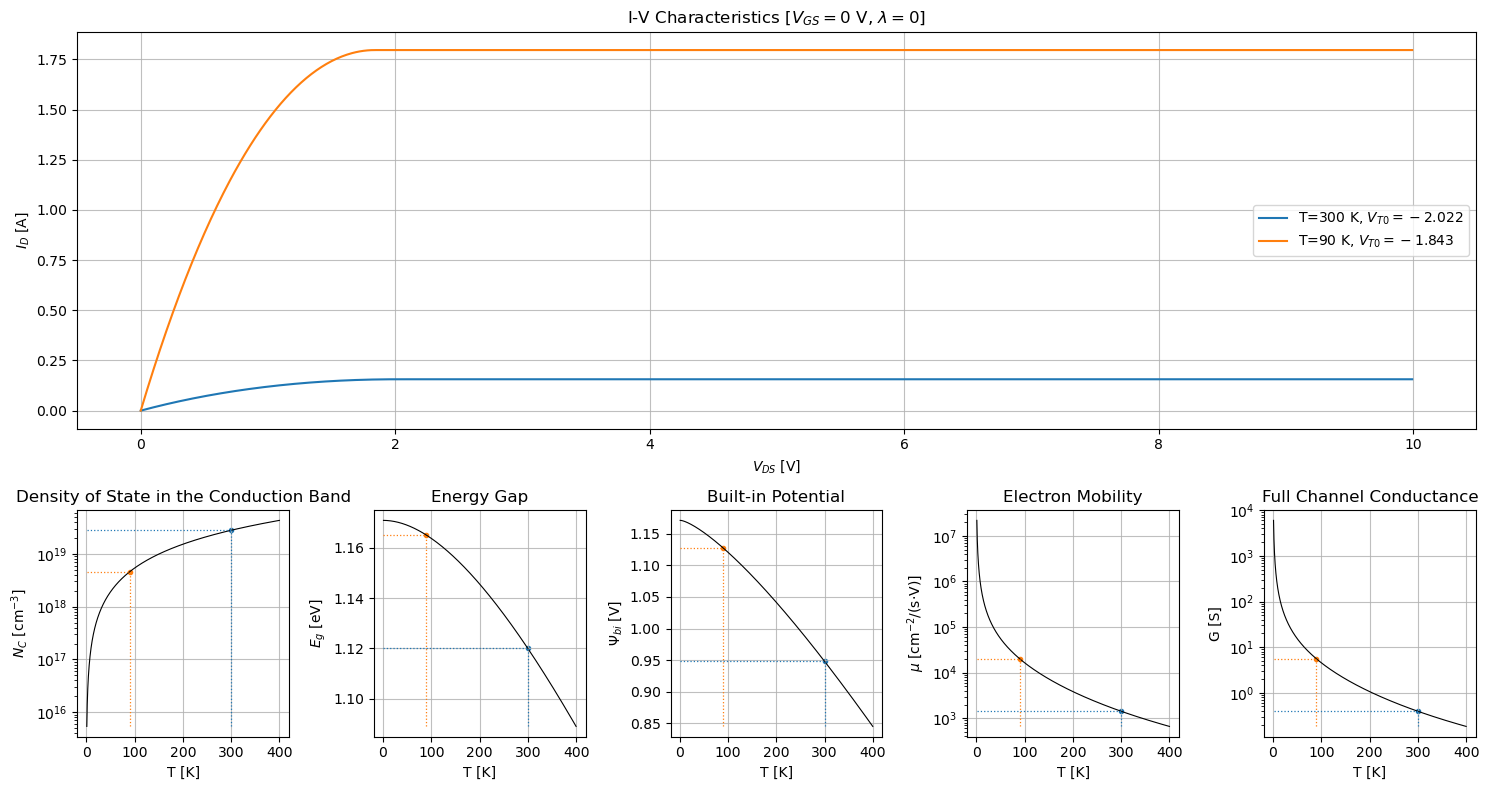

In [10]:
# Params
T_0 = 300
T = 90
lambda_mod = 0
V_gs = 0
T_values = [T_0,T]

# Initialize class
jfet_2=JFET(  
    W_L_ratio = params_de["W_L_ratio"],
    a = params_de["a"],                              
    N_d = params_de["N_d"],        
    )

# Define ranges for plots
Ts = np.arange(1, 400, 0.1)
V_ds = np.arange(0,10,0.01)

# Compute quantities
id_values_2 = [[jfet_2.I_d(V_ds=i, V_gs=V_gs, T=t, lambda_mod=lambda_mod) for i in V_ds] for t in T_values]
N_c_2 = jfet_2.density_of_state_cond_band(Ts)
V_p_2 = round(jfet_2.pinch_off_voltage(),2)
E_g_2 = jfet_2.energy_gap(Ts)
V_bi_2 = jfet_2.built_in_potential(Ts)
mu_2 = [jfet_2.mobility(t) for t in Ts]
G_2 = [jfet_2.full_channel_conductance(m) for m in mu_2]

# Plots
fig = plt.figure(figsize=(15, 8))
gs = fig.add_gridspec(2, 5, height_ratios=[1.75, 1])  

ax0 = fig.add_subplot(gs[0, :])  
for i, t in enumerate(T_values):
    ax0.plot(V_ds, id_values_2[i], label=f"T={t} K, $V_{{T0}}={np.round(jfet_2.built_in_potential(t)-V_p_2,3)}$")
ax0.legend()
ax0.set_xlabel("$V_{DS}$ [V]")
ax0.set_ylabel("$I_{D}$ [A]")
ax0.set_title(f"I-V Characteristics [$V_{{GS}} = {V_gs}$ V, $\lambda = {lambda_mod}$]")
ax0.grid(alpha=0.8)

ax1 = fig.add_subplot(gs[1, 0])
ax1.plot(Ts, N_c_2, label="$N_c(T)$", color="black", lw=0.8)
ax1.scatter(T, jfet_2.density_of_state_cond_band(T), color="tab:orange", marker=".")
ax1.vlines(T,min(N_c_2),jfet_2.density_of_state_cond_band(T), color="tab:orange", ls="dotted", lw=0.9)
ax1.hlines(jfet_2.density_of_state_cond_band(T), min(Ts), T, color="tab:orange", ls="dotted", lw=0.9)
ax1.scatter(T_0, jfet_2.density_of_state_cond_band(T_0), color="tab:blue", marker=".")
ax1.vlines(T_0,min(N_c_2),jfet_2.density_of_state_cond_band(T_0), color="tab:blue", ls="dotted", lw=0.9)
ax1.hlines(jfet_2.density_of_state_cond_band(T_0), min(Ts), T_0, color="tab:blue", ls="dotted", lw=0.9)
ax1.set_yscale("log")
ax1.set_xlabel("T [K]")
ax1.set_ylabel("$N_C$ [cm$^{-3}$]")
ax1.set_title("Density of State in the Conduction Band")
ax1.grid(alpha=0.8)

ax2 = fig.add_subplot(gs[1, 1])
ax2.plot(Ts, E_g_2, label="$\E_g(T)$", color="black", lw=0.8)
ax2.scatter(T, jfet_2.energy_gap(T), color="tab:orange", marker=".")
ax2.vlines(T,min(E_g_2),jfet_2.energy_gap(T), color="tab:orange", ls="dotted", lw=0.9)
ax2.hlines(jfet_2.energy_gap(T), min(Ts), T, color="tab:orange", ls="dotted", lw=0.9)
ax2.scatter(T_0, jfet_2.energy_gap(T_0), color="tab:blue", marker=".")
ax2.vlines(T_0,min(E_g_2),jfet_2.energy_gap(T_0), color="tab:blue", ls="dotted", lw=0.9)
ax2.hlines(jfet_2.energy_gap(T_0), min(Ts), T_0, color="tab:blue", ls="dotted", lw=0.9)
ax2.set_xlabel("T [K]")
ax2.set_ylabel("$E_g$ [eV]")
ax2.set_title("Energy Gap")
ax2.grid(alpha=0.8)

ax3 = fig.add_subplot(gs[1, 2])
ax3.plot(Ts, V_bi_2, label="$\Psi_{bi}(T)$", color="black", lw=0.8)
ax3.scatter(T, jfet_2.built_in_potential(T), color="tab:orange", marker=".")
ax3.vlines(T,min(V_bi_2),jfet_2.built_in_potential(T), color="tab:orange", ls="dotted", lw=0.9)
ax3.hlines(jfet_2.built_in_potential(T), min(Ts), T, color="tab:orange", ls="dotted", lw=0.9)
ax3.scatter(T_0, jfet_2.built_in_potential(T_0), color="tab:blue", marker=".")
ax3.vlines(T_0,min(V_bi_2),jfet_2.built_in_potential(T_0), color="tab:blue", ls="dotted", lw=0.9)
ax3.hlines(jfet_2.built_in_potential(T_0), min(Ts), T_0, color="tab:blue", ls="dotted", lw=0.9)
ax3.set_xlabel("T [K]")
ax3.set_ylabel("$\Psi_{bi}$ [V]")
ax3.set_title("Built-in Potential")
ax3.grid(alpha=0.8)

ax4 = fig.add_subplot(gs[1, 3])
ax4.plot(Ts, mu_2, label="$\mu(T)$", color="black", lw=0.8)
ax4.scatter(T, jfet_2.mobility(T), color="tab:orange", marker=".")
ax4.vlines(T,min(mu_2),jfet_2.mobility(T), color="tab:orange", ls="dotted", lw=0.9)
ax4.hlines(jfet_2.mobility(T), min(Ts), T, color="tab:orange", ls="dotted", lw=0.9)
ax4.scatter(T_0, jfet_2.mobility(T_0), color="tab:blue", marker=".")
ax4.vlines(T_0,min(mu_2),jfet_2.mobility(T_0), color="tab:blue", ls="dotted", lw=0.9)
ax4.hlines(jfet_2.mobility(T_0), min(Ts), T_0, color="tab:blue", ls="dotted", lw=0.9)
ax4.set_yscale("log")
ax4.set_xlabel("T [K]")
ax4.set_ylabel("$\mu$ [cm$^{-2}$/(s$\cdot$V)]")
ax4.set_title("Electron Mobility")
ax4.grid(alpha=0.8)

ax5 = fig.add_subplot(gs[1, 4])
ax5.plot(Ts, G_2, label="$G(T)$", color="black", lw=0.8)
ax5.scatter(T, jfet_2.full_channel_conductance(jfet_2.mobility(T)), color="tab:orange", marker=".")
ax5.vlines(T,min(G_2),jfet_2.full_channel_conductance(jfet_2.mobility(T)), color="tab:orange", ls="dotted", lw=0.9)
ax5.hlines(jfet_2.full_channel_conductance(jfet_2.mobility(T)), min(Ts), T, color="tab:orange", ls="dotted", lw=0.9)
ax5.scatter(T_0, jfet_2.full_channel_conductance(jfet_2.mobility(T_0)), color="tab:blue", marker=".")
ax5.vlines(T_0,min(G_2),jfet_2.full_channel_conductance(jfet_2.mobility(T_0)), color="tab:blue", ls="dotted", lw=0.9)
ax5.hlines(jfet_2.full_channel_conductance(jfet_2.mobility(T_0)), min(Ts), T_0, color="tab:blue", ls="dotted", lw=0.9)
ax5.set_yscale("log")
ax5.set_xlabel("T [K]")
ax5.set_ylabel("G [S]")
ax5.set_title("Full Channel Conductance")
ax5.grid(alpha=0.8)

plt.tight_layout()


# Analysis @ 300 K
mu_2 = jfet_2.mobility(T=300)
G_i_2 = jfet_2.full_channel_conductance(mu_2)
psi_bi_2 = jfet_2.built_in_potential(T=300)
psi_p_2 = jfet_2.pinch_off_voltage()
V_T_2 = psi_bi_2 - psi_p_2

u_s_2 = np.sqrt((psi_bi_2 )/psi_p_2)
g_m_2 = G_i*(1-u_s_2) 

print("class output (T=300K):\n")
print(f" G_i: {G_i_2} \n psi_bi: {psi_bi_2} \n psi_p: {psi_p_2} \n V_TO: {V_T_2}\n\n g_m: {g_m_2} \n")

I_DSS_comp_2 = max(id_values_2[0]) # computed using the JFET_2 class in the cell above
print(f" I_DSS computed: \t{I_DSS_comp_2}")

I_sat_2 = G_i_2 * (psi_p_2/3 - (psi_bi_2) * (1-2/3*u_s_2))
print(f" I_DSS theoretical: \t{I_sat_2} \n")

## Function wrapper

In [11]:
def JFET_simulation(V_DS, V_GS, I_DSS, VTO, g_m, lambda_mod, operating_T, data_sheet_T, method="differential_evolution", verbose=False):
    """
    Function that simulate a JFET with explicit temperature dependace starting from data sheet parameters

    Parameters:
    -----------
    V_DS : scalar or array
        Drain-source voltage [V]
    V_GS : scalar or array
        Gate-source volatage [V]
    I_DSS : float
        Saturation current @ V_gs = 0 [A]
    VTO : float
        Pinch off voltage [V]
    g_m : float
        Transconductance [S]
    lambda_mod : float
        Channel-length modulation factor
    operating_T : float
        Operating temperature of the JFET [K]
    data_sheet_T : float
        Nominal data sheet temperature [K]
    method : str, optional
        Optimization method to use. Options:
        - 'differential_evolution' (default): Uses SciPy's differential evolution
        - 'iminuit': Uses iMinuit for optimization (requires iminuit to be installed)
    verbose : bool, optional
        Display input parameters and infered parameters    

    Returns:
    --------
    array
        Drain-Source current [A]        
    """

    params = infer_jfet_params(I_DSS=I_DSS, VTO=VTO, g_m=g_m, T=data_sheet_T, method=method)

    jfet=JFET(  
        W_L_ratio = params["W_L_ratio"],
        a = params["a"],                               
        N_d = params["N_d"], 
        )
    
    I_D_values = [jfet.I_d(V_ds=v_ds, V_gs=V_GS, T=operating_T, lambda_mod=lambda_mod) for v_ds in V_DS]

    if verbose:
        N_d = params["N_d"]
        W_L_ratio = params["W_L_ratio"]
        a = params["a"]

        print("-------------------------------------------------")
        print("Input params:")
        print(f" I_DSS (@ {data_sheet_T} K): {I_DSS} \n VTO (@ {data_sheet_T} K): {VTO} \n g_m (@ {data_sheet_T} K): {g_m} \n operationg T: {operating_T}")
        print()
        print(f"Infered params ({method}):")
        print(f" N_d: {N_d} \n W_L_ratio: {W_L_ratio} \n a: {a}")
        print("-------------------------------------------------")

    return I_D_values

## MoxTek MX11 JFET simulation


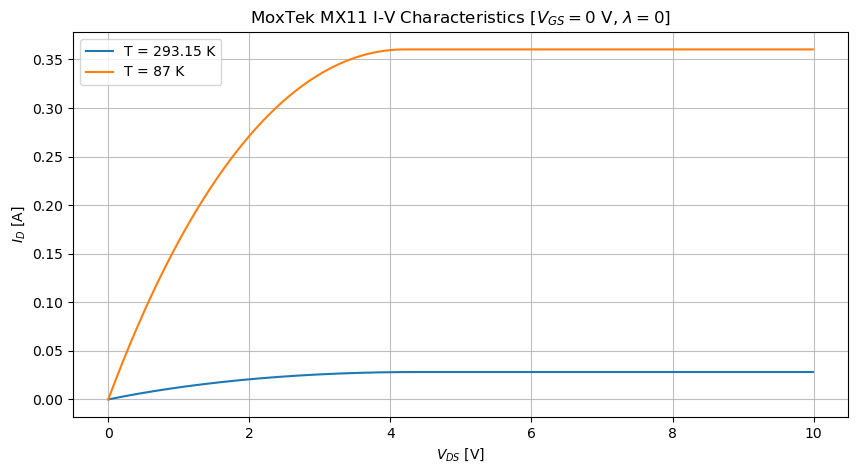

-------------------------------------------------
Input params:
 I_DSS (@ 293.15 K): 0.03 
 VTO (@ 293.15 K): -4.2 
 g_m (@ 293.15 K): 0.0056 
 operationg T: 293.15

Infered params (differential_evolution):
 N_d: 1.6043598754464768e+16 
 W_L_ratio: 0.01000650204860598 
 a: 6.608235543327863e-07
-------------------------------------------------
I_DSS calculated @ 300 K: 0.028206045549217157 A
Difference wrt I_DSS theoretical @ 300 K: 0.001793954450782842


In [12]:
# Data sheet MX11 params
I_DSS = 30e-3
VTO = -4.2
g_m = 5.6e-3

V_DS = np.arange(0,10,0.01)
V_GS = 0

lambda_mod = 0
operating_T = [293.15,87]
data_sheet_T = 293.15

method = "differential_evolution"

data = np.zeros((len(operating_T),len(V_DS)))

for i, t in enumerate(operating_T):
    data[i,:] = JFET_simulation(
        V_DS=V_DS, V_GS=V_GS, I_DSS=I_DSS, VTO=VTO, g_m=g_m, 
        lambda_mod=lambda_mod, operating_T=t, data_sheet_T=data_sheet_T, 
        method=method, verbose=False
        )


plt.figure(figsize=(10,5))
for i, t in enumerate(operating_T):
    plt.plot(V_DS, data[i,:], label=f"T = {t} K")
plt.xlabel("$V_{DS}$ [V]")
plt.ylabel("$I_{D}$ [A]")
plt.title(f"MoxTek MX11 I-V Characteristics [$V_{{GS}} = {V_GS}$ V, $\lambda = {lambda_mod}]$")
plt.legend()
plt.grid(alpha=0.8)
plt.show() 


T=293.15
MX11_at_293 = JFET_simulation(
    V_DS=V_DS, V_GS=V_GS, I_DSS=I_DSS, VTO=VTO, g_m=g_m, 
    lambda_mod=lambda_mod, operating_T=T, data_sheet_T=data_sheet_T, 
    method=method, verbose=True
    )

print(f"I_DSS calculated @ 300 K: {max(MX11_at_293)} A")
if T == data_sheet_T:
    print(f"Difference wrt I_DSS theoretical @ 300 K: {abs(I_DSS-max(MX11_at_293))}")

### BF862

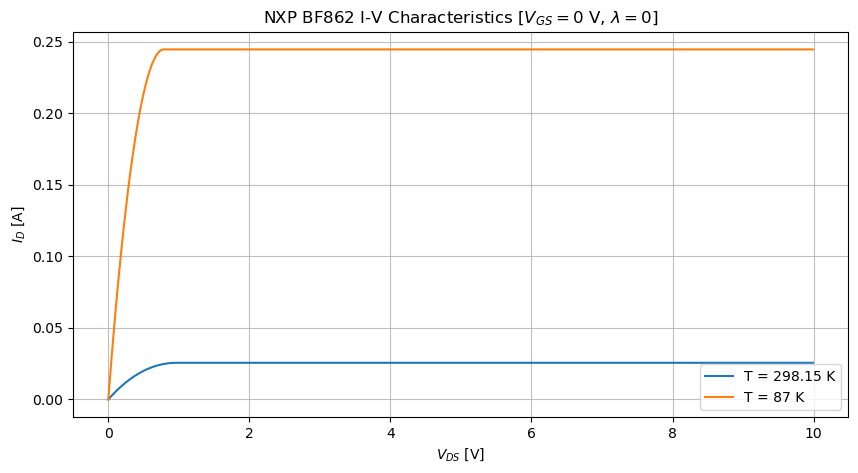

-------------------------------------------------
Input params:
 I_DSS (@ 298.15 K): 0.017 
 VTO (@ 298.15 K): -0.8 
 g_m (@ 298.15 K): 0.045 
 operationg T: 298.15

Infered params (differential_evolution):
 N_d: 3.788561297233306e+16 
 W_L_ratio: 0.08405146727662505 
 a: 2.583288439356444e-07
-------------------------------------------------
I_DSS calculated @ 300 K: 0.02573462943252249 A
Difference wrt I_DSS theoretical @ 300 K: 0.008734629432522487


In [13]:
# BF862 data sheet params
I_DSS = 17e-3
VTO = -0.8
g_m = 45e-3

V_DS = np.arange(0,10,0.01)
V_GS = 0

lambda_mod = 0
operating_T = [298.15,87]
data_sheet_T = 298.15

method = "differential_evolution"
#method = "iminuit"

data = np.zeros((len(operating_T),len(V_DS)))

for i, t in enumerate(operating_T):
    data[i,:] = JFET_simulation(
        V_DS=V_DS, V_GS=V_GS, I_DSS=I_DSS, VTO=VTO, g_m=g_m, 
        lambda_mod=lambda_mod, operating_T=t, data_sheet_T=data_sheet_T, 
        method=method, verbose=False
        )


plt.figure(figsize=(10,5))
for i, t in enumerate(operating_T):
    plt.plot(V_DS, data[i,:], label=f"T = {t} K")
plt.xlabel("$V_{DS}$ [V]")
plt.ylabel("$I_{D}$ [A]")
plt.title(f"NXP BF862 I-V Characteristics [$V_{{GS}} = {V_GS}$ V, $\lambda = {lambda_mod}]$")
plt.legend()
plt.grid(alpha=0.8)
plt.show() 


T=298.15
BF862_at_298 = JFET_simulation(
    V_DS=V_DS, V_GS=V_GS, I_DSS=I_DSS, VTO=VTO, g_m=g_m, 
    lambda_mod=lambda_mod, operating_T=T, data_sheet_T=data_sheet_T, 
    method=method, verbose=True
    )

print(f"I_DSS calculated @ 300 K: {max(BF862_at_298)} A")
if T == data_sheet_T:
    print(f"Difference wrt I_DSS theoretical @ 300 K: {abs(I_DSS-max(BF862_at_298))}")